In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

data = pickle.load(open( "data.pickle", "rb" ))
#data

In [2]:
time = data['t']  #timestamp

x_init  = data['x_init'] #initial x
y_init  = data['y_init'] #initial y
th_init = data['th_init'] #initial theta

# velocity based model
v  = data['v']  #trans velocity input
om = data['om']  #rot velocity input

# range & angle  measurements using LIDAR
b = data['b']  #Angle measurement 
r = data['r']  #range measurement
l = data['l']  #landmarks
d = data['d']  #distance between robot center and laser rangefinder

#print(v.shape)
#print(r.shape)
#print(l.shape)

In [3]:
v_var = 0.004  #trans velocity variance  
om_var = 0.008  #rot velocity variance 
r_var = 0.001  #range measurements variance
b_var = 0.0005  #angle measurements variance

R = np.diag([v_var, om_var,1]) #input noise covariance 
Q = np.diag([r_var, b_var])  #measurement noise covariance 
#print(R)
#print(Q)

In [4]:
#new variables
x_est = np.zeros([len(v), 3])  #estimated x, y, and theta
x_est[0] = np.array([x_init, y_init, th_init]) #initial state
#print(x_est.shape)

C_est = np.zeros([len(v), 3, 3])  #state covariance matrices
C_est[0] = np.diag([1, 1, 0.1])   #initial covariance
#print(C_est.shape)

In [5]:
def wrapToPi(angle):
    return np.arctan2(np.sin(float(angle)),np.cos(float(angle)))

In [6]:
def measurement_correct (lm, am, rm, X_pred, c_pred):
    
    x = X_pred[0]
    y = X_pred[1]
    theta =wrapToPi(X_pred[2])
    
    #LIDAR range angle measurement model
    x1=float(lm[0]-x-d*np.cos(theta))
    y1=float(lm[1]-y-d*np.sin(theta))
    r=float(np.sqrt(x1**2+y1**2))
    phi=wrapToPi(np.arctan2(y1,x1)-theta)
    
    observed = np.array([[r],[phi]])
    measured = np.array([[rm],[wrapToPi(am)]])
     
    #Jacobian for LIDAR model
    H = np.matrix([[-x1/r, -y1/r,d*(x1*np.sin(theta)-y1*np.cos(theta))/r],
                   [y1/r**2,-x1/r**2,-1-d*(y1*np.sin(theta)+x1*np.cos(theta))/r**2]],dtype = 'float')
    #Kalman Gain
    K_G = c_pred @ H.T @ np.linalg.inv(H @ c_pred @ H.T + Q)
    
    #Corrected State and covariance
    X_pred += K_G @ (measured - observed)
    X_pred[2]=wrapToPi(X_pred[2])
    
    c_pred =  (np.eye(3) - K_G @ H) @ c_pred
    
    return X_pred, c_pred

In [7]:
x_pred = x_est[0, :].reshape(3,1)
C_pred = C_est[0]

for i in range(1, len(time)):  # start at 1 because we've set the initial prediciton

    delta_t = time[i] - time[i - 1]  # time step (difference between timestamps)
    x_pred[2] = wrapToPi(x_pred[2])
    theta = x_pred[2]
    
    #Motion Model
    a = v[i-1]/om[i-1]
    g = np.matrix([[-a*np.sin(theta)+a*np.sin(theta+om[i-1]*delta_t)],
                 [a*np.cos(theta)-a*np.cos(theta+om[i-1]*delta_t)],
                 [om[i-1]*delta_t]],dtype = 'float')
    x_pred += g
    x_pred[2] = wrapToPi(x_pred[2])
    
    #Jacobian for motion model
    G = np.matrix([[1, 0, -a*np.cos(theta)+a*np.cos(theta+om[i-1]*delta_t)],
                 [0, 1,-a*np.sin(theta)+a*np.sin(theta+om[i-1]*delta_t)],
                 [0, 0, 1]],dtype = 'float')
    
    C_pred = (G @ C_pred @ G.T) + R
    
    for j in range(len(r[i])):
        x_pred, C_pred = measurement_correct( l[j], b[i,j], r[i,j], x_pred, C_pred)

    x_est[i,0]=x_pred[0]
    x_est[i,1]=x_pred[1]
    x_est[i,2]=x_pred[2]
    
    C_est[i,:,:]= C_pred
    

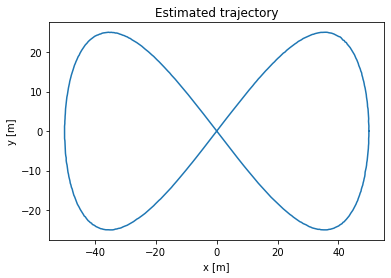

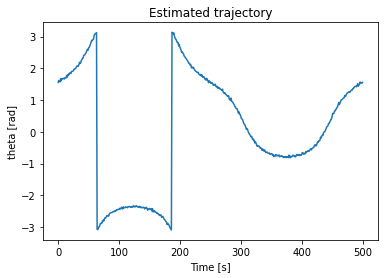

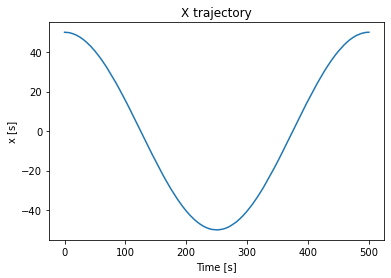

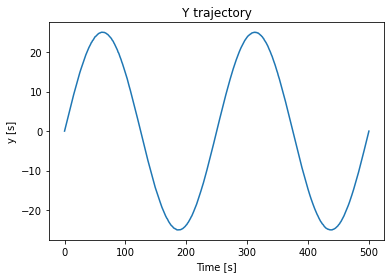

In [8]:
F = plt.figure()
ax = F.add_subplot(111)
ax.plot(x_est[:, 0], x_est[:, 1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Estimated trajectory')
plt.show()

F = plt.figure()
ax=F.add_subplot(111)
ax.plot(time[:], x_est[:, 2])
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Estimated trajectory')
plt.show()

F = plt.figure()
ax=F.add_subplot(111)
ax.plot(time[:], x_est[:, 0])
ax.set_xlabel('Time [s]')
ax.set_ylabel('x [s]')
ax.set_title('X trajectory')
plt.show()

F = plt.figure()
ax=F.add_subplot(111)
ax.plot(time[:], x_est[:, 1])
ax.set_xlabel('Time [s]')
ax.set_ylabel('y [s]')
ax.set_title('Y trajectory')
plt.show()